In [326]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")



from datetime import datetime


#загрузка ордербука
#bbo_1000pepeusdt=pd.read_csv('/Users/anastasiia/Downloads/md_sim/bbo_1000pepeusdt.csv', sep = ',')
#bbo_dogeusdt=pd.read_csv('/Users/anastasiia/Downloads/md_sim/bbo_dogeusdt.csv', sep = ',')


#загрузка трейдов
trades_1000pepeusdt=pd.read_csv('/Users/anastasiia/Downloads/md_sim/trades_1000pepeusdt.csv', sep = ',')
trades_dogeusdt=pd.read_csv('/Users/anastasiia/Downloads/md_sim/trades_dogeusdt.csv', sep = ',')

 
#корректировка времени
#bbo_1000pepeusdt['timestamp']=pd.to_datetime(bbo_1000pepeusdt['local_timestamp'], unit='us')
#bbo_dogeusdt['timestamp']=pd.to_datetime(bbo_dogeusdt['local_timestamp'], unit='us')

trades_1000pepeusdt['timestamp']=pd.to_datetime(trades_1000pepeusdt['local_timestamp'], unit='us')
trades_dogeusdt['timestamp']=pd.to_datetime(trades_dogeusdt['local_timestamp'], unit='us')



#индексы -> время

#bbo_1000pepeusdt.set_index('timestamp',inplace=True)
#bbo_dogeusdt.set_index('timestamp',inplace=True)

trades_1000pepeusdt.set_index('timestamp',inplace=True)
trades_dogeusdt.set_index('timestamp',inplace=True)
 

T='1Min'


In [327]:
#создание OHLC свечей для pepeusdt
pepeusdt_ohlc = trades_1000pepeusdt['price'].resample(T).ohlc()

#объем покупок и продаж 
trades_1000pepeusdt['product']=trades_1000pepeusdt['price']*trades_1000pepeusdt['amount']

#cредняя цена покупок
agg_trades_1000pepeusdt_buy=trades_1000pepeusdt[trades_1000pepeusdt['side']=='buy'].groupby(pd.Grouper(freq=T))[['product','amount']].sum()

agg_trades_1000pepeusdt_buy['avg_price']=agg_trades_1000pepeusdt_buy['product']/agg_trades_1000pepeusdt_buy['amount']

agg_trades_1000pepeusdt_buy=agg_trades_1000pepeusdt_buy[['amount','avg_price']].rename(columns={'amount':'traded'}).add_suffix('_buy')

#средняя цена продаж
agg_trades_1000pepeusdt_sell=trades_1000pepeusdt[trades_1000pepeusdt['side']=='sell'].groupby(pd.Grouper(freq=T))[['product','amount']].sum()

agg_trades_1000pepeusdt_sell['avg_price']=agg_trades_1000pepeusdt_sell['product']/agg_trades_1000pepeusdt_sell['amount']

agg_trades_1000pepeusdt_sell=agg_trades_1000pepeusdt_sell[['amount','avg_price']].rename(columns={'amount':'traded'}).add_suffix('_sell')
pepeusdt_ohlc['amount'] = trades_1000pepeusdt['amount'].groupby(pd.Grouper(freq=T)).sum()

pepeusdt_ohlc=pepeusdt_ohlc.join(agg_trades_1000pepeusdt_buy).join(agg_trades_1000pepeusdt_sell)



#создание OHLC свечей для dogeusdt
dogeusdt_ohlc = trades_dogeusdt['price'].resample(T).ohlc()

#объем покупок и продаж 
trades_dogeusdt['product']=trades_dogeusdt['price']*trades_dogeusdt['amount']

#cредняя цена покупок
agg_trades_dogeusdt_buy=trades_dogeusdt[trades_dogeusdt['side']=='buy'].groupby(pd.Grouper(freq=T))[['product','amount']].sum()

agg_trades_dogeusdt_buy['avg_price']=agg_trades_dogeusdt_buy['product']/agg_trades_dogeusdt_buy['amount']

agg_trades_dogeusdt_buy=agg_trades_dogeusdt_buy[['amount','avg_price']].rename(columns={'amount':'traded'}).add_suffix('_buy')


#средняя цена продаж
agg_trades_dogeusdt_sell=trades_dogeusdt[trades_dogeusdt['side']=='sell'].groupby(pd.Grouper(freq=T))[['product','amount']].sum()

agg_trades_dogeusdt_sell['avg_price']=agg_trades_dogeusdt_sell['product']/agg_trades_dogeusdt_sell['amount']

agg_trades_dogeusdt_sell=agg_trades_dogeusdt_sell[['amount','avg_price']].rename(columns={'amount':'traded'}).add_suffix('_sell')
dogeusdt_ohlc['amount'] = trades_dogeusdt['amount'].groupby(pd.Grouper(freq=T)).sum()

dogeusdt_ohlc=dogeusdt_ohlc.join(agg_trades_dogeusdt_buy).join(agg_trades_dogeusdt_sell)

del bbo_1000pepeusdt,bbo_dogeusdt,trades_1000pepeusdt,trades_dogeusdt,agg_trades_dogeusdt_buy,agg_trades_dogeusdt_sell,agg_trades_1000pepeusdt_sell,agg_trades_1000pepeusdt_buy

#возвращаемся к исходным индексам
pepeusdt_ohlc = pepeusdt_ohlc.reset_index(drop= False , inplace= False)
dogeusdt_ohlc = dogeusdt_ohlc.reset_index(drop= False , inplace= False)

#сохранение свечей в файл
pepeusdt_ohlc.to_csv('/Users/anastasiia/Downloads/md_sim/pepeusdt_ohlc.csv')
dogeusdt_ohlc.to_csv('/Users/anastasiia/Downloads/md_sim/dogeusdt_ohlc.csv')

In [328]:
dogeusdt_ohlc['amount'] = dogeusdt_ohlc['amount'].astype(float)
pepeusdt_ohlc['amount'] = pepeusdt_ohlc['amount'].astype(float)

In [330]:
#симулятор
def trade_simulator(ohlc_df, actions_df, mode='close'):
    result = actions_df.copy()
    result['OpenPosition'] = 0  #колво инструментов
    result['PositionPrice'] = 0  #средняя цена в момент открытия
    result['PnL'] = 0  

    result = result.join(ohlc_df[['close', 'low', 'high']])
    
    for r, row in result.iterrows():
        if r == 0:
            continue

        prev_row = result.iloc[r - 1]

        action = prev_row['Action']
        open_position = prev_row['OpenPosition']
        position_price = prev_row['PositionPrice']
        
        #нчего не делаем
        if action == 0:
            result.at[r, 'OpenPosition'] = open_position
            result.at[r, 'PositionPrice'] = position_price
            
        #покупаем
        elif action > 0:  
            new_position = open_position + action
            if mode == 'close':
                new_price = row['close']
            elif mode == 'average':
                new_price = (row['low'] + row['high']) / 2
            
            #обновляем среднюю цену
            if open_position > 0:
                new_avg_price = (open_position * position_price + action * new_price) / new_position
            else:
                new_avg_price = new_price  #если не было открытых позиций раньше
            
            result.at[r, 'OpenPosition'] = new_position
            result.at[r, 'PositionPrice'] = new_avg_price
            
        #продаем
        elif action < 0:  
            if mode == 'close':
                new_price = row['close']
            elif mode == 'average':
                new_price = (row['low'] + row['high']) / 2
            new_position = open_position + action
            
            if new_position < 0:
                result.at[r, 'PositionPrice'] = (open_position * position_price + action * new_price) / new_position
            
            elif new_position > 0:
                result.at[r, 'PositionPrice'] = (open_position * position_price + action * new_price) / new_position
            elif new_position == 0:
                result.at[r, 'PositionPrice'] = 0
            
            result.at[r, 'OpenPosition'] = new_position
            
        #PnL для каждой свечки
        if action < 0:  
            result.at[r-1, 'PnL'] = (prev_row['close'] - position_price) * (-action)
        else:
            result.at[r-1, 'PnL'] = 0  

    #заполняем пропуски значениями из предыдущих строк
    result.ffill(inplace=True)
    result['PositionPrice'] = result['PositionPrice'].astype(float)
    result['PnL'] = result['PnL'].astype(float)
    return result


In [331]:
def calculate_statistics(result_df):
        result_df['TradedVolume'] = result_df['OpenPosition'].abs()

        #общее значение прибыли/убытка PnL
        pnl = result_df['PnL'].sum()

        #общий объем проторгованных контрактов
        traded_volume = result_df['TradedVolume'].sum()

        #максимальная просадка
        cumulative_pnl = result_df['PnL'].cumsum()
        #max_drawdown = (cumulative_pnl.cummax() - cumulative_pnl).max() 

        # Рассчитываем капитал с учетом начальной суммы
        result_df['Equity'] =result_df['PnL'].fillna(0).cumsum()

        # Находим максимальные значения капитала на каждом шаге
        cumulative_max = np.maximum.accumulate(result_df['Equity'])

        # Вычисляем относительную просадку с защитой от деления на 0
        drawdown = np.where(cumulative_max > 0, (cumulative_max - result_df['Equity']) / cumulative_max, 0)

        # Максимальная просадка
        max_drawdown = drawdown.max()

    
        result_df['returns'] = result_df['PnL'].pct_change()
        result_df['returns'] = result_df['returns'].replace([np.inf, -np.inf], np.nan)
        result_df = result_df.dropna(subset=['returns'])

        risk_free_rate = 0.00  # Безрисковая ставка

        # Sharpe Ratio
        returns_std = result_df['returns'].std()
        sharpe_ratio = (result_df['returns'].mean() - risk_free_rate) / (returns_std if returns_std > 0 else np.nan)

        # Sortino Ratio
        downside_std = result_df.loc[result_df['returns'] < 0, 'returns'].std()
        sortino_ratio = (result_df['returns'].mean() - risk_free_rate) / (downside_std if downside_std > 0 else np.nan)

        #переходы через 0
        number_of_flips = (((result_df['OpenPosition'] > 0) & (result_df['OpenPosition'].shift(1) < 0)) |
                        ((result_df['OpenPosition'] < 0) & (result_df['OpenPosition'].shift(1) > 0))).sum()




        stats_dict = {
        'PnL': pnl,
        'TradedVolume': traded_volume,
        'SharpeRatio': sharpe_ratio,
        'SortinoRatio': sortino_ratio,
        'MaxDrawdown': max_drawdown,
        'NumberOfPositionFlips': number_of_flips
        }
    
        stats_df = pd.DataFrame(stats_dict, index=[0])
        return stats_df

In [391]:
#случайная стратегия

def random_strategy_short(ohlc_df):
    actions = np.random.choice([-1, 0, 1], size=len(ohlc_df))
    contract_size = np.random.randint(100000000, 400000000, size=len(ohlc_df)) 
    ohlc_df['Action'] = actions * contract_size
    return ohlc_df[['Action']]

In [393]:
def perfect_foresight_strategy_risk(ohlc_df, risk_factor=0.2):
    position = 0  # Начальное количество инструмента
    actions = [] 
    total_capital = 1000000  # Примерный размер капитала
    capital_at_risk = total_capital * risk_factor  # Сколько капитала можно использовать для сделок
    for i in range(len(ohlc_df) - 1):
        current_price = ohlc_df['close'].iloc[i]
        future_price = ohlc_df['close'].iloc[i + 1]
        action = 0  

        # Расчет размера позиции, исходя из рискового капитала
        if future_price > current_price:
            action = min(capital_at_risk // current_price, ohlc_df['amount'].iloc[i])  # Покупаем, не превышая рисковую сумму
            position += action
        elif future_price < current_price and position > 0:
            action = -position  # Продаем
            position += action
      
        actions.append(action)

    actions.append(0)  # Завершаем без активных позиций
    ohlc_df['Action'] = np.array(actions)
    return ohlc_df[['Action']]

In [395]:
def perfect_foresight_strategy(ohlc_df):
    position = 0  #начальное количество инстр
    actions = [] 
    for i in range(len(ohlc_df) - 1):
        current_price = ohlc_df['close'].iloc[i]
        future_price = ohlc_df['close'].iloc[i + 1]
        action = 0  

        if future_price > current_price:
            action = ohlc_df['amount'].iloc[i]
            position += action
        elif future_price < current_price:
            action = -position  #продаем 
            position = 0
      
        actions.append(action)

    actions.append(0) 
    ohlc_df['Action'] = np.array(actions)
    return ohlc_df[['Action']]

In [397]:
def perfect_foresight_strategy_avg(ohlc_df):
    position = 0  # начальное количество инструментов
    actions = [] 
    total_price = 0  # Общая сумма, потраченная на покупку
    total_avg_price = 0  # Средняя цена покупки

    for i in range(len(ohlc_df) - 1):
        current_price = ohlc_df['close'].iloc[i]  # Текущая цена
        future_price = ohlc_df['close'].iloc[i + 1]  # Будущая цена
        action = 0  # Стартовое действие (без покупки/продажи)

        # Если будущее значение больше текущей средней, покупаем
        if future_price > total_avg_price:
            action = ohlc_df['amount'].iloc[i]  # Покупаем на сумму "amount" в этой строке
            position += action  # Увеличиваем количество в позиции
            total_price += current_price * action  # Добавляем потраченную сумму
            total_avg_price = total_price / position  # Обновляем среднюю цену
        # Если будущее значение меньше текущей средней, продаем все
        elif future_price < total_avg_price and position > 0:
            action = -position  # Продаем все позиции
            total_price = 0  # Обнуляем потраченную сумму
            total_avg_price = 0  # Сбрасываем среднюю цену
            position = 0  # Убираем все позиции

            
        actions.append(action)
    actions.append(0) 
    ohlc_df['Action'] = np.array(actions)
    return ohlc_df[['Action']]

In [399]:
#данные для симуляции
perfect_actions = perfect_foresight_strategy(dogeusdt_ohlc)
perfect_actions_risk = perfect_foresight_strategy_risk(dogeusdt_ohlc)
perfect_actions_avg = perfect_foresight_strategy_avg(dogeusdt_ohlc)
random_actions_short = random_strategy_short(dogeusdt_ohlc)


#симулируем торговлю для случайной стратегии short
random_simulation_short = trade_simulator(dogeusdt_ohlc, random_actions_short, mode='close')
random_stats_short = calculate_statistics(random_simulation_short)
print('Случайная стратегия short')
print(random_stats_short)

#симулируем торговлю для идеальной стратегии
perfect_simulation = trade_simulator(dogeusdt_ohlc, perfect_actions, mode='close')
perfect_stats = calculate_statistics(perfect_simulation)
print('Стратегия с идеальным знанием будущего')
print(perfect_stats)

#симулируем торговлю для идеальной стратегии с риск-фактором
perfect_simulation_risk = trade_simulator(dogeusdt_ohlc, perfect_actions_risk, mode='close')
perfect_stats_risk = calculate_statistics(perfect_simulation_risk)
print('Стратегия с идеальным знанием будущего с рисками')
print(perfect_stats)

#симулируем торговлю для идеальной стратегии со средним
perfect_simulation_avg = trade_simulator(dogeusdt_ohlc, perfect_actions_avg, mode='close')
perfect_stats_avg = calculate_statistics(perfect_simulation_avg)
print('Стратегия с идеальным знанием будущего (среднее)')
print(perfect_stats)



Случайная стратегия short
            PnL     TradedVolume  SharpeRatio  SortinoRatio  MaxDrawdown  \
0 -1.043637e+09  124930818256000     0.012842      0.778005    91.698027   

   NumberOfPositionFlips  
0                     26  
Стратегия с идеальным знанием будущего
            PnL  TradedVolume  SharpeRatio  SortinoRatio  MaxDrawdown  \
0  1.204172e+06   22146660588          NaN           NaN          0.0   

   NumberOfPositionFlips  
0                      0  
Стратегия с идеальным знанием будущего с рисками
            PnL  TradedVolume  SharpeRatio  SortinoRatio  MaxDrawdown  \
0  1.204172e+06   22146660588          NaN           NaN          0.0   

   NumberOfPositionFlips  
0                      0  
Стратегия с идеальным знанием будущего (среднее)
            PnL  TradedVolume  SharpeRatio  SortinoRatio  MaxDrawdown  \
0  1.204172e+06   22146660588          NaN           NaN          0.0   

   NumberOfPositionFlips  
0                      0  


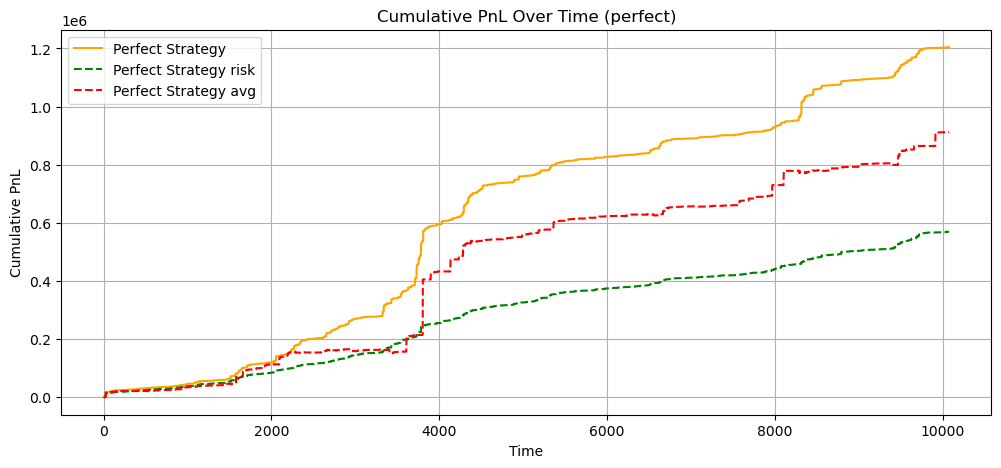

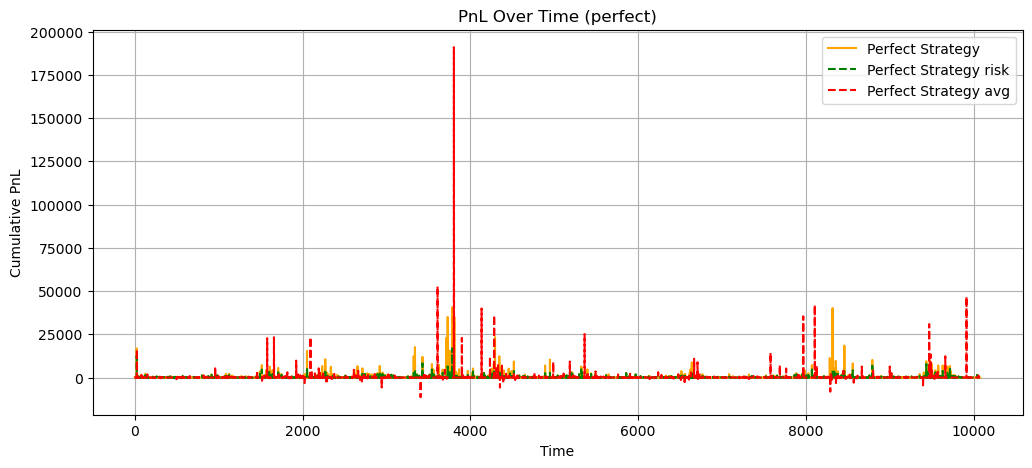

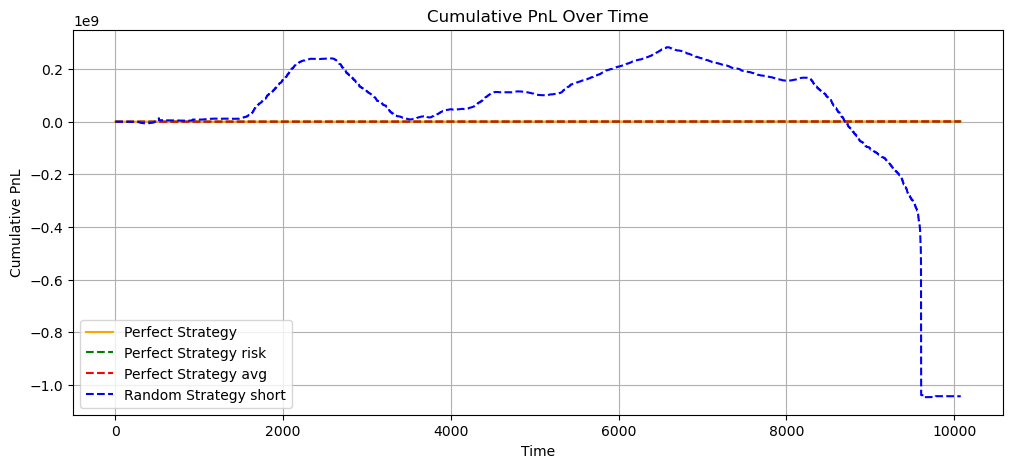

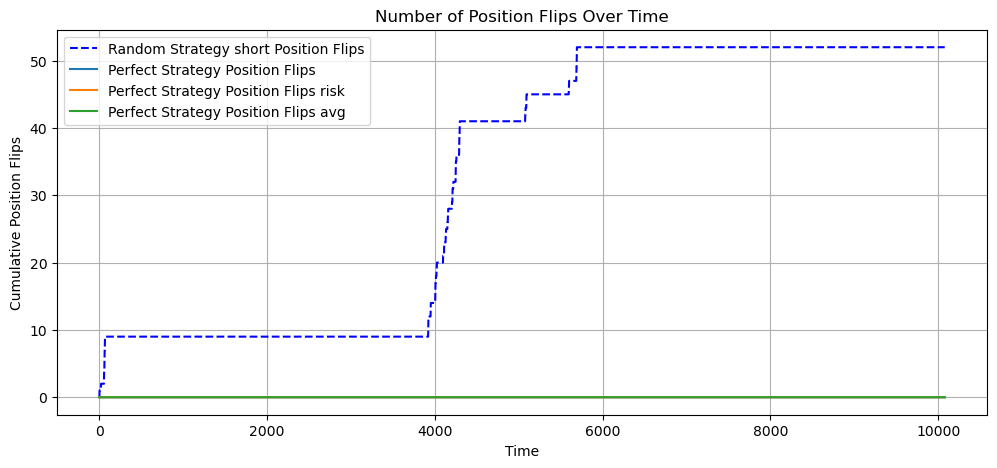

In [435]:
import matplotlib.pyplot as plt

# График PnL для идеальных стратегий (куммулятивный)
plt.figure(figsize=(12, 5))

plt.plot(perfect_simulation['PnL'].cumsum(), label='Perfect Strategy', linestyle='solid', color='orange')
plt.plot(perfect_simulation_risk['PnL'].cumsum(), label='Perfect Strategy risk', linestyle='dashed', color='green')
plt.plot(perfect_simulation_avg['PnL'].cumsum(), label='Perfect Strategy avg', linestyle='dashed', color='red')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.title('Cumulative PnL Over Time (perfect)')
plt.legend()
plt.grid()
plt.show()

# График PnL идеальной стратегии (поточечный)
plt.figure(figsize=(12, 5))

plt.plot(perfect_simulation['PnL'], label='Perfect Strategy', linestyle='solid', color='orange')
plt.plot(perfect_simulation_risk['PnL'], label='Perfect Strategy risk', linestyle='dashed', color='green')
plt.plot(perfect_simulation_avg['PnL'], label='Perfect Strategy avg', linestyle='dashed', color='red')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.title('PnL Over Time (perfect)')
plt.legend()
plt.grid()
plt.show()


# График PnL для случайной и идеальных стратегий (куммулятивный)
plt.figure(figsize=(12, 5))

plt.plot(perfect_simulation['PnL'].cumsum(), label='Perfect Strategy', linestyle='solid', color='orange')
plt.plot(perfect_simulation_risk['PnL'].cumsum(), label='Perfect Strategy risk', linestyle='dashed', color='green')
plt.plot(perfect_simulation_avg['PnL'].cumsum(), label='Perfect Strategy avg', linestyle='dashed', color='red')
plt.plot(random_simulation_short['PnL'].cumsum(), label='Random Strategy short', linestyle='dashed', color='blue')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.title('Cumulative PnL Over Time')
plt.legend()
plt.grid()
plt.show()

# График NumberOfPositionFlips 
random_flips_cumsum = (((random_simulation_short['OpenPosition'] > 0) & (random_simulation_short['OpenPosition'].shift(1) < 0)) |
        ((random_simulation_short['OpenPosition'] < 0) & (random_simulation_short['OpenPosition'].shift(1) > 0))).cumsum()

perfect_flips_cumsum = (((perfect_simulation['OpenPosition'] > 0) & (perfect_simulation['OpenPosition'].shift(1) < 0)) |
        ((perfect_simulation['OpenPosition'] < 0) & (perfect_simulation['OpenPosition'].shift(1) > 0))).cumsum()
perfect_flips_risk_cumsum = (((perfect_simulation_risk['OpenPosition'] > 0) & (perfect_simulation_risk['OpenPosition'].shift(1) < 0)) |
        ((perfect_simulation_risk['OpenPosition'] < 0) & (perfect_simulation_risk['OpenPosition'].shift(1) > 0))).cumsum()
perfect_flips_avg_cumsum = (((perfect_simulation_avg['OpenPosition'] > 0) & (perfect_simulation_avg['OpenPosition'].shift(1) < 0)) |
        ((perfect_simulation_avg['OpenPosition'] < 0) & (perfect_simulation_avg['OpenPosition'].shift(1) > 0))).cumsum()

plt.figure(figsize=(12, 5))
plt.plot(random_short_flips_cumsum, label='Random Strategy short Position Flips', linestyle='dashed', color='blue')
plt.plot(perfect_flips_cumsum, label='Perfect Strategy Position Flips', linestyle='solid')
plt.plot(perfect_flips_risk_cumsum, label='Perfect Strategy Position Flips risk', linestyle='solid')
plt.plot(perfect_flips_avg_cumsum, label='Perfect Strategy Position Flips avg', linestyle='solid')
plt.xlabel('Time')
plt.ylabel('Cumulative Position Flips')
plt.title('Number of Position Flips Over Time')
plt.legend()
plt.grid()
plt.show()


In [436]:
#MA

#считаем среднее скользящее (МА). Если цена выше МА, то покупаем. Если цена ниже, то продаем
#для pepeusdt

pepeusdt_ohlc['MA'] = pepeusdt_ohlc['close'].rolling(window=5).mean()

vol=pepeusdt_ohlc['close'].std()/2 #деление ну просто так (чтобы побольше точек было)

k = np.random.randint(1, 200)

pepeusdt_ohlc['Action']=pepeusdt_ohlc.apply(lambda x: -k if x['close']<x['MA']-vol else k if x['close']> x['MA']+vol else 0,axis=1).fillna(0)

pepeusdt_actions_MA = pepeusdt_ohlc[['Action']]

pepeusdt_ohlc=pepeusdt_ohlc.drop(columns=['MA', 'Action'])





#для dogeusdt

dogeusdt_ohlc['MA'] = dogeusdt_ohlc['close'].rolling(window=5).mean()

vol=dogeusdt_ohlc['close'].std()/2 #деление ну просто так (чтобы побольше точек было)

k = np.random.randint(1, 200)

dogeusdt_ohlc['Action']=dogeusdt_ohlc.apply(lambda x: -k if x['close']<x['MA']-vol else k if x['close']> x['MA']+vol else 0,axis=1).fillna(0)

dogeusdt_actions_MA=dogeusdt_ohlc[['Action']]

dogeusdt_ohlc=dogeusdt_ohlc.drop(columns=['MA','Action'])


In [439]:
#  Стратегия на основе скользящей средней (МА) 

pepeusdt_ohlc['MA'] = pepeusdt_ohlc['close'].rolling(window=5).mean()
dogeusdt_ohlc['MA'] = dogeusdt_ohlc['close'].rolling(window=5).mean()

pepeusdt_ohlc['vol'] = pepeusdt_ohlc['close'].rolling(window=5, min_periods=1).std() / 2
dogeusdt_ohlc['vol'] = dogeusdt_ohlc['close'].rolling(window=5, min_periods=1).std() / 2

pepeusdt_ohlc['k'] = np.random.randint(100000000, 500000000, size=len(pepeusdt_ohlc))
dogeusdt_ohlc['k'] = np.random.randint(100000000, 500000000, size=len(dogeusdt_ohlc))

#действия по MA
pepeusdt_ohlc['Action'] = pepeusdt_ohlc.apply(
    lambda x: -x['k'] if x['close'] < x['MA'] - x['vol'] else x['k'] if x['close'] > x['MA'] + x['vol'] else 0, axis=1
).fillna(0)

dogeusdt_ohlc['Action'] = dogeusdt_ohlc.apply(
    lambda x: -x['k'] if x['close'] < x['MA'] - x['vol'] else x['k'] if x['close'] > x['MA'] + x['vol'] else 0, axis=1
).fillna(0)


pepeusdt_actions_MA = pepeusdt_ohlc[['Action']]
dogeusdt_actions_MA = dogeusdt_ohlc[['Action']]

pepeusdt_ohlc.drop(columns=['MA', 'vol', 'k', 'Action'], inplace=True)
dogeusdt_ohlc.drop(columns=['MA', 'vol', 'k', 'Action'], inplace=True)





In [441]:
#Стратегия на основе корреляции CORR
corr_calculator = dogeusdt_ohlc[['close']].add_suffix('_doge').join(pepeusdt_ohlc[['close']].add_suffix('_pepe'))

corr_calculator['corr'] = corr_calculator['close_doge'].rolling(window=10, min_periods=2).corr(corr_calculator['close_pepe'])
corr_calculator['corr'].fillna(corr_calculator['corr'].mean(), inplace=True)


corr_calculator['avg'] = corr_calculator['corr'].rolling(window=10, min_periods=2).mean()
corr_calculator['vol'] = corr_calculator['corr'].rolling(window=10, min_periods=2).std()


corr_calculator['k'] = np.random.randint(100000000, 500000000, size=len(corr_calculator))

#действия по корреляции
corr_calculator['Action_doge'] = corr_calculator.apply(
    lambda x: -x['k'] if x['corr'] < x['avg'] - x['vol'] else x['k'] if x['corr'] > x['avg'] + x['vol'] else 0, axis=1
).fillna(0)


corr_calculator['Action_pepe'] = corr_calculator['Action_doge'].apply(lambda x: abs(x) if x < 0 else -abs(x) if x > 0 else 0)


dogeusdt_actions_CORR = corr_calculator[['Action_doge']].rename(columns={'Action_doge': 'Action'})
pepeusdt_actions_CORR = corr_calculator[['Action_pepe']].rename(columns={'Action_pepe': 'Action'})
actions_pair = corr_calculator[['Action_doge', 'Action_pepe']]

corr_calculator.drop(columns=['avg', 'vol', 'k'], inplace=True)

actions_pair.to_csv('/Users/anastasiia/Downloads/md_sim/actions_pair.csv', index=False)

In [443]:
#стратегии среднее скользящее и корреляция на скользящем окне PEPE
#СИМУЛЯЦИЯ MA
pepeusdt_result_MA = trade_simulator(pepeusdt_ohlc, pepeusdt_actions_MA, mode = 'close')
pepeusdt_result_MA.to_csv('/Users/anastasiia/Downloads/md_sim/pepeusdt_result_MA.csv')

pepeusdt_result_CORR = trade_simulator(pepeusdt_ohlc, pepeusdt_actions_CORR, mode = 'close')
pepeusdt_result_CORR.to_csv('/Users/anastasiia/Downloads/md_sim/pepeusdt_result_CORR.csv')

#СТАТИСТИКИ
pepeusdt_stats_MA = calculate_statistics(pepeusdt_result_MA)
pepeusdt_stats_CORR = calculate_statistics(pepeusdt_result_CORR)
print('PEPEUSDT Stats MA')
print(pepeusdt_stats_MA)
print('PEPEUSDT Stats CORR')
print(pepeusdt_stats_CORR)

PEPEUSDT Stats MA
            PnL     TradedVolume  SharpeRatio  SortinoRatio  MaxDrawdown  \
0 -2.560866e+07  232961125278341     0.014565        0.0756    63.263285   

   NumberOfPositionFlips  
0                     19  
PEPEUSDT Stats CORR
            PnL      TradedVolume  SharpeRatio  SortinoRatio  MaxDrawdown  \
0 -1.835143e+08  1095566004001414    -0.032839     -0.026697  2480.179194   

   NumberOfPositionFlips  
0                      2  


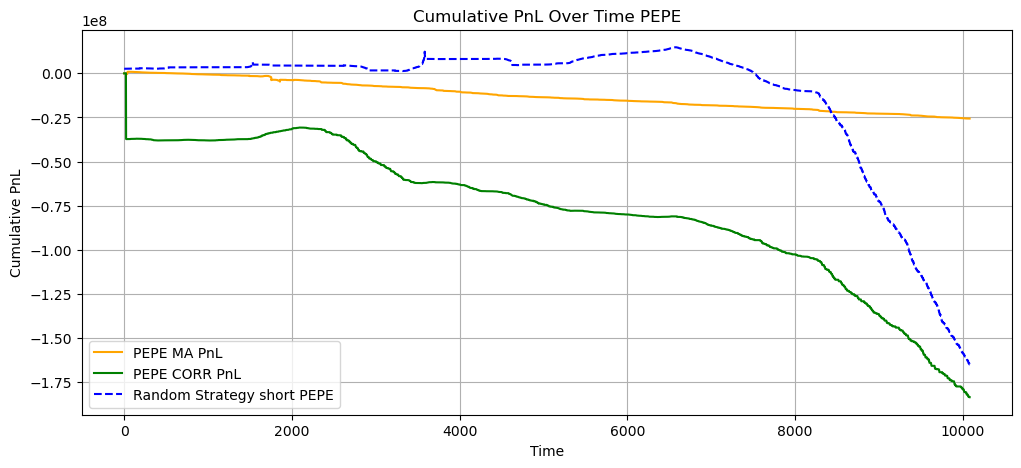

In [444]:
# График PnL для MA и CORR стратегий (куммулятивный) PEPE
plt.figure(figsize=(12, 5))

random_actions_short_pepe = random_strategy_short(pepeusdt_ohlc)
random_simulation_short_pepe = trade_simulator(pepeusdt_ohlc, random_actions_short_pepe, mode='close')

plt.plot(pepeusdt_result_MA['PnL'].cumsum(), label='PEPE MA PnL', linestyle='solid', color='orange')
plt.plot(pepeusdt_result_CORR['PnL'].cumsum(), label='PEPE CORR PnL', linestyle='solid', color='green')
plt.plot(random_simulation_short_pepe['PnL'].cumsum(), label='Random Strategy short PEPE', linestyle='dashed', color='blue')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.title('Cumulative PnL Over Time PEPE')
plt.legend()
plt.grid()
plt.show()


In [446]:
#стратегии среднее скользящее и корреляция на скользящем окне DOGE
#СИМУЛЯЦИЯ MA
dogeusdt_result_MA = trade_simulator(dogeusdt_ohlc, dogeusdt_actions_MA, mode = 'close')
dogeusdt_result_MA.to_csv('/Users/anastasiia/Downloads/md_sim/dogeusdt_result_MA.csv')

dogeusdt_result_CORR = trade_simulator(dogeusdt_ohlc, dogeusdt_actions_CORR, mode = 'close')
dogeusdt_result_CORR.to_csv('/Users/anastasiia/Downloads/md_sim/dogeusdt_result_CORR.csv')

#СТАТИСТИКИ
dogeusdt_stats_MA = calculate_statistics(dogeusdt_result_MA)
dogeusdt_stats_CORR = calculate_statistics(dogeusdt_result_CORR)
print('DOGEUSDT Stats MA')
print(dogeusdt_stats_MA)
print('DOGEUSDT Stats CORR')
print(dogeusdt_stats_CORR)

DOGEUSDT Stats MA
            PnL     TradedVolume  SharpeRatio  SortinoRatio  MaxDrawdown  \
0 -2.530577e+08  164502876969590      -0.0002     -0.000211      4.28167   

   NumberOfPositionFlips  
0                     56  
DOGEUSDT Stats CORR
            PnL      TradedVolume  SharpeRatio  SortinoRatio  MaxDrawdown  \
0  3.595389e+07  1095566004001414    -0.016668     -0.014039     0.550271   

   NumberOfPositionFlips  
0                      2  


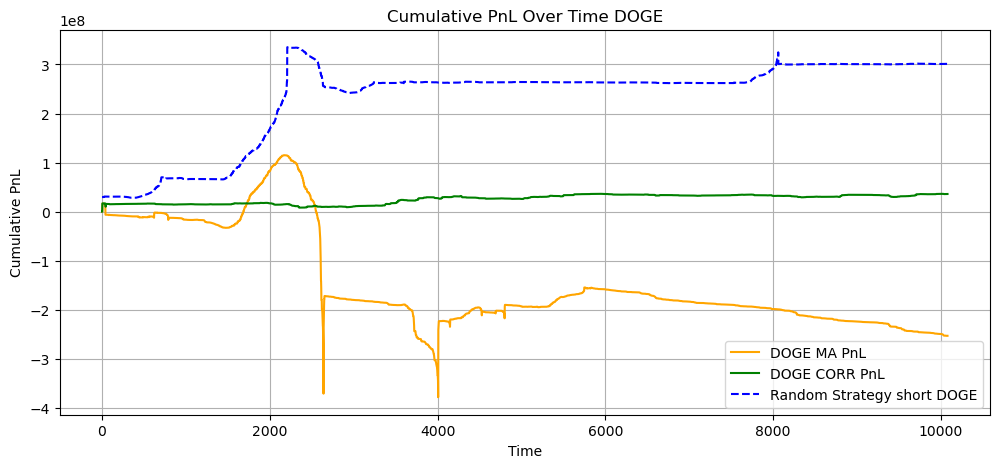

In [449]:
# График PnL для MA и CORR стратегий (куммулятивный) DOGE
plt.figure(figsize=(12, 5))

random_actions_short_doge = random_strategy_short(dogeusdt_ohlc)
random_simulation_short_doge = trade_simulator(dogeusdt_ohlc, random_actions_short_doge, mode='close')

plt.plot(dogeusdt_result_MA['PnL'].cumsum(), label='DOGE MA PnL', linestyle='solid', color='orange')
plt.plot(dogeusdt_result_CORR['PnL'].cumsum(), label='DOGE CORR PnL', linestyle='solid', color='green')
plt.plot(random_simulation_short_doge['PnL'].cumsum(), label='Random Strategy short DOGE', linestyle='dashed', color='blue')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.title('Cumulative PnL Over Time DOGE')
plt.legend()
plt.grid()
plt.show()